# Linear Regression

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error

In [40]:
class PerFeatureTransformer:
    def __init__(self):
        """Initializes memory for per-feature transformers."""
        self.transformers = {}
        self.feature_types = {}
        
    def fit(self, df: pd.DataFrame, params: dict[str, str]) -> None:
        """
        Fits transformers for each feature based on the given type.
        """
        self.feature_types = params
        
        for feature, transform_type in self.feature_types.items():
            if feature not in df.columns:
                continue
                
            if transform_type == "standard":
                scaler = StandardScaler()
                scaler.fit(df[[feature]])
                self.transformers[feature] = scaler
                
            elif transform_type == "ordinal":
                encoder = OrdinalEncoder()
                encoder.fit(df[[feature]])
                self.transformers[feature] = encoder
                
            elif transform_type == "onehot":
                encoder = OneHotEncoder(sparse_output=False, drop='first')
                encoder.fit(df[[feature]])
                self.transformers[feature] = encoder
                
    def transform(self, df: pd.DataFrame) -> np.ndarray:
        """Applies the fitted transformers to the corresponding features and returns a NumPy array."""
        transformed_features = []
        
        for feature, transform_type in self.feature_types.items():
            if feature not in df.columns:
                continue

            transformer = self.transformers[feature]
            transformed = transformer.transform(df[[feature]])
      
            if len(transformed.shape) == 2 and transformed.shape[1] > 1:
                transformed_features.append(transformed)
            else:
                transformed_features.append(transformed.reshape(-1, 1))
                
        return np.concatenate(transformed_features, axis=1)
    
    def fit_transform(self, df: pd.DataFrame, params: dict[str, str]) -> np.ndarray:
        """Fits and transforms all features in one step using the given transformation parameters."""
        self.fit(df, params)
        return self.transform(df)

In [41]:
def run_poly_regression(X_train, y_train, X_val, y_val, X_test, y_test, 
                       degree=1, regularizer=None, reg_strength=0.0):
    """
    Polynomial regression with optional L1/L2 regularization.
    """
    
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    X_test_poly = poly.transform(X_test)
    
    if regularizer is None:
        model = LinearRegression()
    elif regularizer == 'l1':
        model = Lasso(alpha=reg_strength, max_iter=2000)
    elif regularizer == 'l2':
        model = Ridge(alpha=reg_strength)
    else:
        raise ValueError("regularizer must be None, 'l1', or 'l2'")
    
    model.fit(X_train_poly, y_train)
    
    y_train_pred = model.predict(X_train_poly)
    y_val_pred = model.predict(X_val_poly)
    y_test_pred = model.predict(X_test_poly)

    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    coefficients = model.coef_
    
    return {
        'train_mse': train_mse,
        'val_mse': val_mse,
        'test_mse': test_mse,
        'coefficients': coefficients,
        'feature_names': poly.get_feature_names_out(),
        'model': model,
        'poly_transformer': poly
    }

In [42]:
class LinearRegressionAnalyzer:
    """
    Class to analyze polynomial regression with different degrees and regularization.
    """
    
    def __init__(self, student_df: pd.DataFrame, username: str):
        """Initialize the analyzer with student dataset."""
        self.df = student_df.copy()
        self.username = username
        self.feature_transformer = PerFeatureTransformer()
        self.X_train = None
        self.X_val = None
        self.X_test = None
        self.y_train = None
        self.y_val = None
        self.y_test = None
        self.degree_analysis_results = {}
        self.best_configurations = {}
        self.final_results = {}
        
    def _add_watermark(self, ax):
        """Add username watermark to plots."""
        ax.text(0.95, 0.95, self.username, ha='right', va='top', 
                transform=ax.transAxes, fontsize=10, color='gray', alpha=0.7)
    
    def prepare_data(self, test_size=0.2, val_size=0.2, seed=42):
        """
        Data preparation: split into train, val, test and encode categorical features.
        """
        features = ['gender', 'major', 'program']
        X = self.df[features].copy()
        y = self.df['GPA'].values

        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y, test_size=test_size, random_state=seed
        )
        
        val_size_adjusted = val_size / (1 - test_size)
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=val_size_adjusted, random_state=seed
        )

        transform_params = {
            'gender': 'onehot',
            'major': 'onehot', 
            'program': 'onehot'
        }
        
        self.X_train = self.feature_transformer.fit_transform(X_train, transform_params)
        self.X_val = self.feature_transformer.transform(X_val)
        self.X_test = self.feature_transformer.transform(X_test)
        self.y_train = y_train
        self.y_val = y_val
        self.y_test = y_test
        
        print(f"Dataset: {self.df.shape[0]} total samples")
        print(f"Train: {self.X_train.shape[0]} samples, {self.X_train.shape[1]} features")
        print(f"Validation: {self.X_val.shape[0]} samples")
        print(f"Test: {self.X_test.shape[0]} samples")
        print(f"GPA range: {y.min():.2f} - {y.max():.2f}")
        return self.X_train, self.X_val, self.X_test, self.y_train, self.y_val, self.y_test
    
    def analyze_polynomial_degrees(self, degrees=range(1, 7), regularizers=[None, 'l1', 'l2']):
        """
        Polynomial degree analysis for different regularization methods.
        """
        
        results = {}
        
        for regularizer in regularizers:
            reg_name = regularizer if regularizer else "None"
            print(f"{reg_name} Regularization")
            
            train_mses = []
            val_mses = []
            test_mses = []
            
            for degree in degrees:
                result = run_poly_regression(
                    self.X_train, self.y_train, self.X_val, self.y_val, self.X_test, self.y_test,
                    degree=degree, 
                    regularizer=regularizer, 
                    reg_strength=0.01 if regularizer else 0.0
                )
                
                train_mses.append(result['train_mse'])
                val_mses.append(result['val_mse'])
                test_mses.append(result['test_mse'])
                
                print(f"  Degree {degree}: Train MSE={result['train_mse']:.6f}, "
                      f"Val MSE={result['val_mse']:.6f}")
            
            results[regularizer] = {
                'degrees': list(degrees),
                'train_mses': train_mses,
                'val_mses': val_mses,
                'test_mses': test_mses
            }
        
        self.degree_analysis_results = results
        self._plot_degree_analysis(results)
        self._analyze_trends(results)
        return results
    
    def _plot_degree_analysis(self, results):
        """Plot polynomial degree vs MSE for all regularization methods."""
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        for i, (regularizer, result) in enumerate(results.items()):
            ax = axes[i]
            reg_name = regularizer if regularizer else "None"
            
            ax.plot(result['degrees'], result['train_mses'], 'bo-', 
                   label='Training MSE', linewidth=2, markersize=6)
            ax.plot(result['degrees'], result['val_mses'], 'ro-', 
                   label='Validation MSE', linewidth=2, markersize=6)
            
            ax.set_xlabel('Polynomial Degree')
            ax.set_ylabel('Mean Squared Error')
            ax.set_title(f'{reg_name} Regularization')
            ax.legend()
            ax.grid(True, alpha=0.3)
            ax.set_xticks(result['degrees'])
            
            best_degree_idx = np.argmin(result['val_mses'])
            best_degree = result['degrees'][best_degree_idx]
            best_val_mse = result['val_mses'][best_degree_idx]
            
            ax.plot(best_degree, best_val_mse, 'go', markersize=10, alpha=0.7)
            ax.annotate(f'Best: {best_degree}', xy=(best_degree, best_val_mse), 
                       xytext=(5, 5), textcoords='offset points', fontsize=9)
            
            self._add_watermark(ax)
        
        plt.tight_layout()
        plt.show()
    
    def _analyze_trends(self, results):
        """Analyze and print trends observed in degree analysis."""
        for regularizer, result in results.items():
            reg_name = regularizer if regularizer else "None"
            print(f"{reg_name} Regularization:")
            
            train_start = result['train_mses'][0]
            train_end = result['train_mses'][-1]
            train_trend = "decreasing" if train_end < train_start else "increasing"
            
            val_start = result['val_mses'][0]
            val_end = result['val_mses'][-1]
            val_trend = "decreasing" if val_end < val_start else "increasing"
            print(f"Training MSE: {train_trend} with increasing degree")
            print(f"Validation MSE: {val_trend} with increasing degree")
            
            best_degree_idx = np.argmin(result['val_mses'])
            best_degree = result['degrees'][best_degree_idx]
            print(f"Best degree: {best_degree} (Val MSE: {result['val_mses'][best_degree_idx]:.6f})")
    
    def tune_regularization_strength(self, regularizers=['l1', 'l2'], reg_strengths=None):
        """
        Tune regularization strengths for the best polynomial degree found previously.
        """
        if reg_strengths is None:
            reg_strengths = np.logspace(-4, 2, 20)  # From 0.0001 to 100
        
        best_configs = {}
        
        for regularizer in regularizers:
            degree_results = self.degree_analysis_results[regularizer]
            best_degree_idx = np.argmin(degree_results['val_mses'])
            best_degree = degree_results['degrees'][best_degree_idx]
            
            print(f"\n--- Tuning {regularizer.upper()} for degree {best_degree} ---")
            
            val_mses = []
            for strength in reg_strengths:
                result = run_poly_regression(
                    self.X_train, self.y_train, self.X_val, self.y_val, self.X_test, self.y_test,
                    degree=best_degree, regularizer=regularizer, reg_strength=strength
                )
                val_mses.append(result['val_mse'])
            
            best_strength_idx = np.argmin(val_mses)
            best_strength = reg_strengths[best_strength_idx]
            best_val_mse = val_mses[best_strength_idx]
            
            best_configs[regularizer] = {
                'degree': best_degree,
                'reg_strength': best_strength,
                'val_mse': best_val_mse
            }
            
            print(f"Best regularization strength: {best_strength:.6f}")
            print(f"Best validation MSE: {best_val_mse:.6f}")

            self._plot_regularization_tuning(reg_strengths, val_mses, best_strength, 
                                           best_val_mse, regularizer, best_degree)

        no_reg_results = self.degree_analysis_results[None]
        best_no_reg_idx = np.argmin(no_reg_results['val_mses'])
        best_configs[None] = {
            'degree': no_reg_results['degrees'][best_no_reg_idx],
            'reg_strength': 0.0,
            'val_mse': no_reg_results['val_mses'][best_no_reg_idx]
        }
        
        self.best_configurations = best_configs
        return best_configs
    
    def _plot_regularization_tuning(self, reg_strengths, val_mses, best_strength, 
                                   best_val_mse, regularizer, degree):
        """Plot regularization strength vs validation MSE."""
        plt.figure(figsize=(10, 6))
        plt.semilogx(reg_strengths, val_mses, 'bo-', linewidth=2, markersize=6)
        plt.semilogx(best_strength, best_val_mse, 'ro', markersize=10, alpha=0.8)
        
        plt.xlabel('Regularization Strength (log scale)')
        plt.ylabel('Validation MSE')
        plt.title(f'{regularizer.upper()} Regularization Strength vs Validation MSE (Degree {degree})')
        plt.grid(True, alpha=0.3)
        
        plt.annotate(f'Best α={best_strength:.4f}', 
                    xy=(best_strength, best_val_mse), xytext=(10, 10), 
                    textcoords='offset points', fontsize=10,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.7))
        
        self._add_watermark(plt.gca())
        plt.tight_layout()
        plt.show()
    
    def compare_final_performance(self):
        """
        Final performance comparison on test set using best configurations.
        """
        if not self.best_configurations:
            raise RuntimeError("Run regularization tuning first.")

        final_results = {}
        print(f"{'Method':<12} {'Degree':<8} {'Reg Strength':<15} {'Val MSE':<12} {'Test MSE':<12}")
        print("-" * 70)
        
        for regularizer, config in self.best_configurations.items():
            result = run_poly_regression(
                self.X_train, self.y_train, self.X_val, self.y_val, self.X_test, self.y_test,
                degree=config['degree'],
                regularizer=regularizer,
                reg_strength=config['reg_strength']
            )
            
            final_results[regularizer] = result
            reg_name = regularizer if regularizer else "None"
            
            print(f"{reg_name:<12} {config['degree']:<8} {config['reg_strength']:<15.6f} "
                  f"{result['val_mse']:<12.6f} {result['test_mse']:<12.6f}")
        
        best_method = min(final_results.keys(), key=lambda k: final_results[k]['test_mse'])
        best_test_mse = final_results[best_method]['test_mse']
        best_reg_name = best_method if best_method else "None"
        
        print(f"BEST OVERALL PERFORMANCE: {best_reg_name} Regularization")
        print(f"Test MSE: {best_test_mse:.6f}")
        print(f"Configuration: Degree {self.best_configurations[best_method]['degree']}, "
              f"Strength {self.best_configurations[best_method]['reg_strength']:.6f}")

        self._analyze_regularization_impact(final_results)
        self.final_results = final_results
        return final_results
    
    def _analyze_regularization_impact(self, final_results):
        """Analyze the impact of regularization on performance."""
        none_mse = final_results[None]['test_mse']
        l1_mse = final_results['l1']['test_mse']
        l2_mse = final_results['l2']['test_mse']
        
        if l1_mse < none_mse:
            improvement = ((none_mse - l1_mse) / none_mse) * 100
            print(f"L1 improves over no regularization by {improvement:.2f}%")
        else:
            degradation = ((l1_mse - none_mse) / none_mse) * 100
            print(f"L1 performs {degradation:.2f}% worse than no regularization")
        
        if l2_mse < none_mse:
            improvement = ((none_mse - l2_mse) / none_mse) * 100
            print(f"L2 improves over no regularization by {improvement:.2f}%")
        else:
            degradation = ((l2_mse - none_mse) / none_mse) * 100
            print(f"L2 performs {degradation:.2f}% worse than no regularization")
        
    def analyze_feature_importance(self):
        """
        Feature importance analysis for L1 vs L2 regularization.
        """
        if not self.final_results:
            raise RuntimeError("Run final performance comparison first.")
        
        l1_config = self.best_configurations['l1']
        l2_config = self.best_configurations['l2']
        
        print(f"\n--- L1 REGULARIZATION (Lasso) ---")
        print(f"Configuration: Degree {l1_config['degree']}, Strength {l1_config['reg_strength']:.6f}")
        
        l1_result = run_poly_regression(
            self.X_train, self.y_train, self.X_val, self.y_val, self.X_test, self.y_test,
            degree=l1_config['degree'], regularizer='l1', reg_strength=l1_config['reg_strength']
        )

        l1_coeffs = l1_result['coefficients']
        l1_features = l1_result['feature_names']
        l1_nonzero_mask = np.abs(l1_coeffs) > 1e-6
        l1_nonzero_coeffs = l1_coeffs[l1_nonzero_mask]
        l1_nonzero_features = l1_features[l1_nonzero_mask]
        
        print(f"Total features: {len(l1_coeffs)}")
        print(f"Non-zero features selected by L1: {len(l1_nonzero_coeffs)}")
        print(f"Sparsity: {((len(l1_coeffs) - len(l1_nonzero_coeffs)) / len(l1_coeffs) * 100):.1f}% features eliminated")
        
        print(f"\nMost important features (L1):")
        l1_importance_order = np.argsort(np.abs(l1_nonzero_coeffs))[::-1]
        for i in range(min(10, len(l1_nonzero_coeffs))):
            idx = l1_importance_order[i]
            feature_name = l1_nonzero_features[idx]
            coeff_value = l1_nonzero_coeffs[idx]
            print(f"  {i+1:2d}. {feature_name}: {coeff_value:.6f}")
        
        print(f"\n--- L2 REGULARIZATION (Ridge) ---")
        print(f"Configuration: Degree {l2_config['degree']}, Strength {l2_config['reg_strength']:.6f}")
        
        l2_result = run_poly_regression(
            self.X_train, self.y_train, self.X_val, self.y_val, self.X_test, self.y_test,
            degree=l2_config['degree'], regularizer='l2', reg_strength=l2_config['reg_strength']
        )

        l2_coeffs = l2_result['coefficients']
        l2_features = l2_result['feature_names']
        
        print(f"Total features: {len(l2_coeffs)}")
        print(f"All features retained (Ridge shrinks but doesn't eliminate)")
        
        print(f"\nMost important features (L2 - by magnitude):")
        l2_importance_order = np.argsort(np.abs(l2_coeffs))[::-1]
        for i in range(min(10, len(l2_coeffs))):
            idx = l2_importance_order[i]
            feature_name = l2_features[idx]
            coeff_value = l2_coeffs[idx]
            print(f"  {i+1:2d}. {feature_name}: {coeff_value:.6f}")

        self._compare_l1_vs_l2(l1_result, l2_result, l1_nonzero_features, 
                              l1_importance_order, l2_features, l2_importance_order)
        self._plot_coefficient_comparison(l1_result, l2_result)
        
        return l1_result, l2_result
    
    def _compare_l1_vs_l2(self, l1_result, l2_result, l1_features, l1_order, l2_features, l2_order):
        """Compare L1 vs L2 feature importance."""
        print(f"\n=== L1 vs L2 COMPARISON ===")
        print(f"L1 (Lasso): Performs feature selection - {len(l1_features)} out of {len(l1_result['coefficients'])} features")
        print(f"L2 (Ridge): Shrinks all coefficients - retains all {len(l2_result['coefficients'])} features")

        l1_top_features = set(l1_features[l1_order[:5]] if len(l1_features) >= 5 else l1_features)
        l2_top_features = set(l2_features[l2_order[:5]])
        common_features = l1_top_features.intersection(l2_top_features)
        
        if common_features:
            print(f"\nFeatures important in both methods: {', '.join(common_features)}")
        else:
            print(f"\nNo common features in top 5 of both methods")
    
    def _plot_coefficient_comparison(self, l1_result, l2_result):
        """Visualize coefficient comparison between L1 and L2."""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
        l1_coeffs = l1_result['coefficients']
        l1_nonzero_mask = np.abs(l1_coeffs) > 1e-6
        l1_nonzero_coeffs = l1_coeffs[l1_nonzero_mask]
        
        if len(l1_nonzero_coeffs) > 0:
            x_positions_l1 = np.arange(len(l1_nonzero_coeffs))
            ax1.bar(x_positions_l1, l1_nonzero_coeffs, color='blue', alpha=0.7)
            ax1.set_title(f'L1 Regularization - Non-zero Coefficients\\n({len(l1_nonzero_coeffs)} features selected)')
            ax1.set_xlabel('Feature Index')
            ax1.set_ylabel('Coefficient Value')
            ax1.grid(True, alpha=0.3)
        else:
            ax1.text(0.5, 0.5, 'No non-zero coefficients', ha='center', va='center',
                    transform=ax1.transAxes, fontsize=12)
            ax1.set_title('L1 Regularization - No Features Selected')

        l2_coeffs = l2_result['coefficients']
        n_top_coeffs = min(20, len(l2_coeffs)) 
        top_indices = np.argsort(np.abs(l2_coeffs))[-n_top_coeffs:]
        top_coeffs = l2_coeffs[top_indices]
        
        x_positions_l2 = np.arange(len(top_coeffs))
        ax2.bar(x_positions_l2, top_coeffs, color='red', alpha=0.7)
        ax2.set_title(f'L2 Regularization - Top {len(top_coeffs)} Coefficients\\n(All {len(l2_coeffs)} features retained)')
        ax2.set_xlabel(f'Feature Rank (Top {len(top_coeffs)})')
        ax2.set_ylabel('Coefficient Value')
        ax2.grid(True, alpha=0.3)
        
        self._add_watermark(ax1)
        self._add_watermark(ax2)
        plt.tight_layout()
        plt.show()
    
    def run_complete_analysis(self, degrees=range(1, 7)):
        """The complete analysis pipeline."""
        self.prepare_data()
        self.analyze_polynomial_degrees(degrees=degrees)
        self.tune_regularization_strength()
        self.compare_final_performance()
        self.analyze_feature_importance()
        
        return {
            'degree_analysis': self.degree_analysis_results,
            'best_configurations': self.best_configurations,
            'final_results': self.final_results
        }

Dataset: 10000 total samples
Train: 6000 samples, 7 features
Validation: 2000 samples
Test: 2000 samples
GPA range: 4.00 - 10.00
None Regularization
  Degree 1: Train MSE=0.814471, Val MSE=0.843210
  Degree 2: Train MSE=0.811772, Val MSE=0.844144
  Degree 3: Train MSE=0.811233, Val MSE=0.846535
  Degree 3: Train MSE=0.811233, Val MSE=0.846535
  Degree 4: Train MSE=0.811233, Val MSE=0.846535
  Degree 4: Train MSE=0.811233, Val MSE=0.846535
  Degree 5: Train MSE=0.811233, Val MSE=0.846535
  Degree 5: Train MSE=0.811233, Val MSE=0.846535
  Degree 6: Train MSE=0.811233, Val MSE=0.846535
l1 Regularization
  Degree 1: Train MSE=0.817015, Val MSE=0.845175
  Degree 2: Train MSE=0.817015, Val MSE=0.845175
  Degree 3: Train MSE=0.817015, Val MSE=0.845175
  Degree 4: Train MSE=0.817015, Val MSE=0.845175
  Degree 6: Train MSE=0.811233, Val MSE=0.846535
l1 Regularization
  Degree 1: Train MSE=0.817015, Val MSE=0.845175
  Degree 2: Train MSE=0.817015, Val MSE=0.845175
  Degree 3: Train MSE=0.817015,

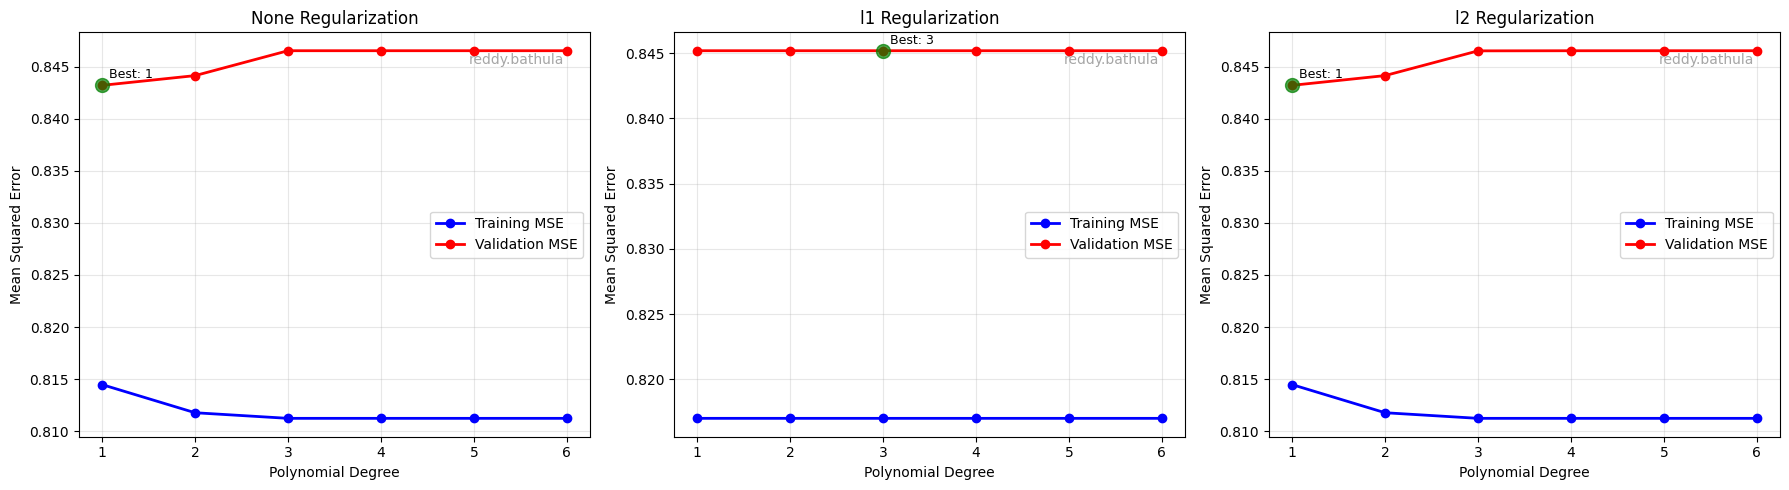

None Regularization:
Training MSE: decreasing with increasing degree
Validation MSE: increasing with increasing degree
Best degree: 1 (Val MSE: 0.843210)
l1 Regularization:
Training MSE: decreasing with increasing degree
Validation MSE: decreasing with increasing degree
Best degree: 3 (Val MSE: 0.845175)
l2 Regularization:
Training MSE: decreasing with increasing degree
Validation MSE: increasing with increasing degree
Best degree: 1 (Val MSE: 0.843210)

--- Tuning L1 for degree 3 ---
Best regularization strength: 0.003793
Best validation MSE: 0.843654
Best regularization strength: 0.003793
Best validation MSE: 0.843654


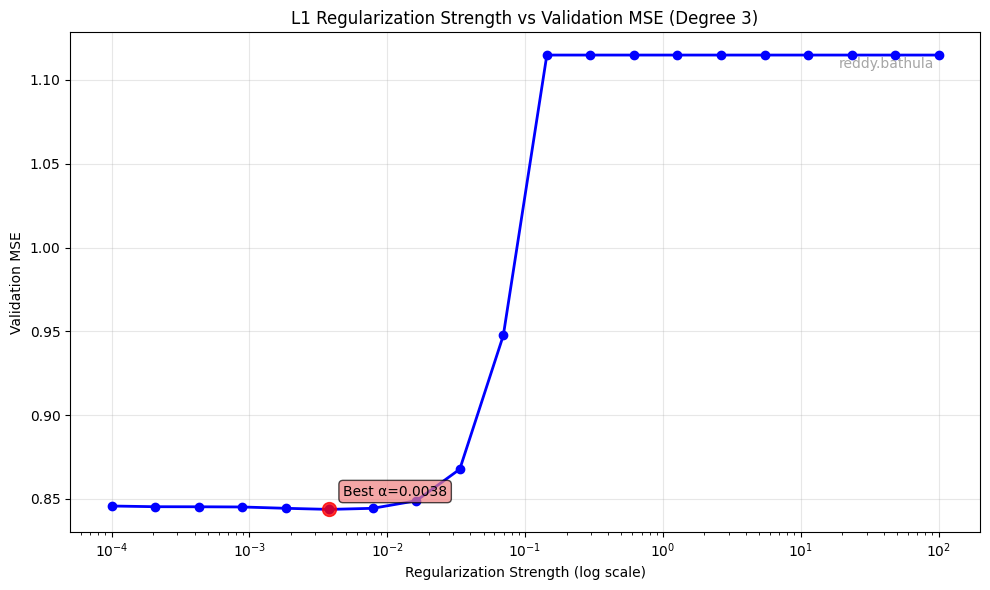


--- Tuning L2 for degree 1 ---
Best regularization strength: 0.000100
Best validation MSE: 0.843210


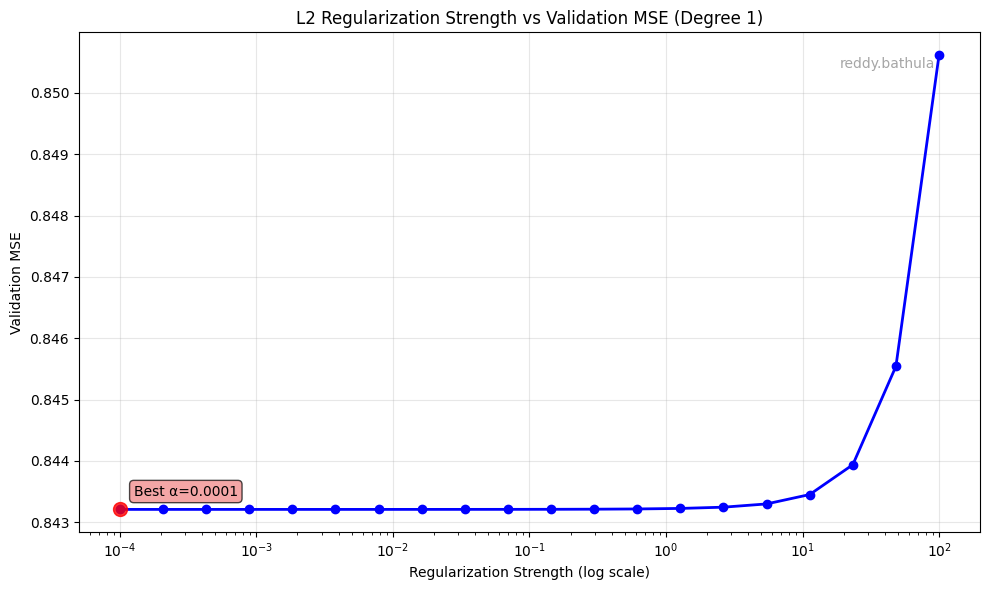

Method       Degree   Reg Strength    Val MSE      Test MSE    
----------------------------------------------------------------------
l1           3        0.003793        0.843654     0.798263    
l2           1        0.000100        0.843210     0.798183    
None         1        0.000000        0.843210     0.798183    
BEST OVERALL PERFORMANCE: None Regularization
Test MSE: 0.798183
Configuration: Degree 1, Strength 0.000000
L1 performs 0.01% worse than no regularization
L2 performs 0.00% worse than no regularization

--- L1 REGULARIZATION (Lasso) ---
Configuration: Degree 3, Strength 0.003793
Total features: 119
Non-zero features selected by L1: 12
Sparsity: 89.9% features eliminated

Most important features (L1):
   1. x3: 1.237943
   2. x2: 0.795199
   3. x2^2: 0.156273
   4. x3^2: 0.034119
   5. x0 x4: 0.017702
   6. x0^2 x5: 0.010648
   7. x0 x5: 0.008064
   8. x2^3: 0.004911
   9. x3^3: 0.002096
  10. x0 x4^2: 0.001595

--- L2 REGULARIZATION (Ridge) ---
Configuration: Degre

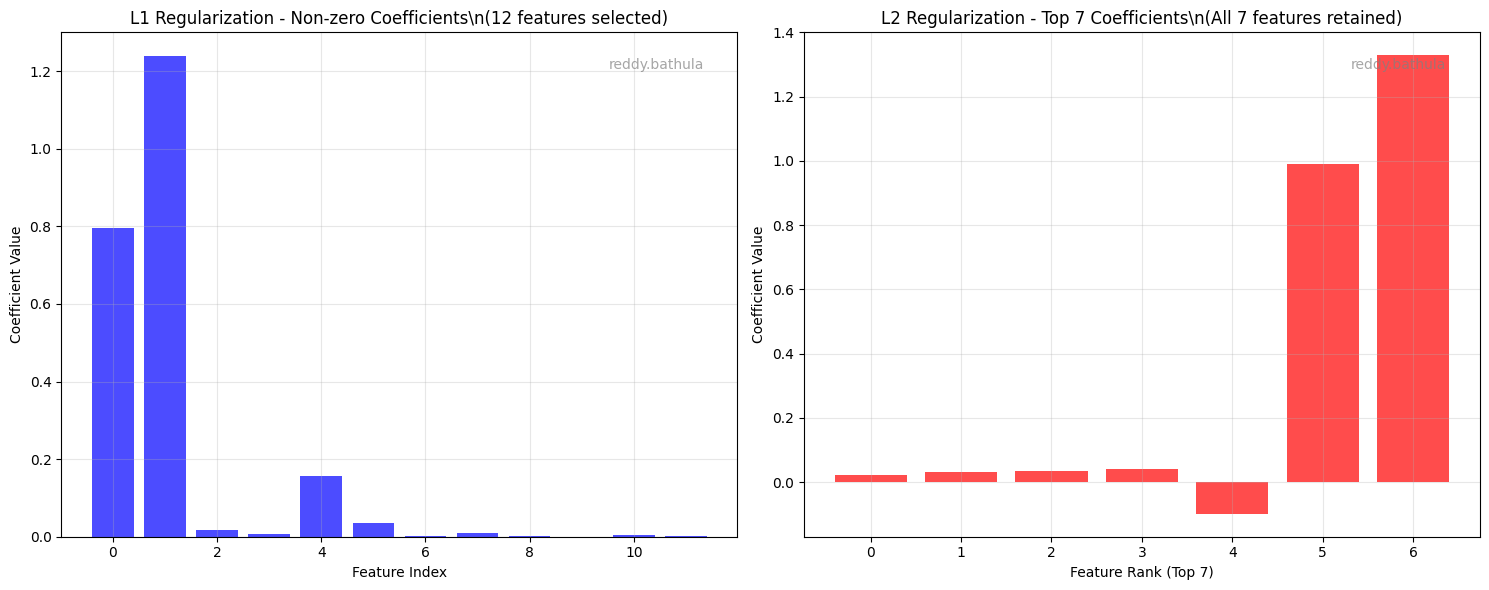

In [43]:
df = pd.read_csv('Dataset/student_dataset.csv')
analyzer = LinearRegressionAnalyzer(df, "reddy.bathula")
results = analyzer.run_complete_analysis(degrees=range(1, 7))